In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
clist = ['royalblue', 'white', 'r']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.style.use('default')
sns.set_color_codes()

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.cal'] = 'Arial'
rcParams['mathtext.it'] = 'Arial'
rcParams['mathtext.rm'] = 'Arial'

import os, re
os.chdir('./ModulePy/')

## 准备LATEX表格

In [2]:
from astropy.time import Time

########### MJD Topo To Bary ###########
pks_data                    = pd.read_csv('../Data/Parkes-DM.csv')
pks_data.columns            = ['mjd_bary', 'dm', 'dme']
pks_data                    = pks_data.sort_values(by='mjd_bary')
pks_data                    = pks_data.reset_index(drop=True)

pks_data.loc[:, 'DM']       = pks_data.loc[:, 'dm'].round(decimals=1).map(lambda x: format(x, '.1f')) + '$\pm$' + \
                              pks_data.loc[:, 'dme'].round(decimals=1).apply(str)
pks_data                    = pks_data.loc[:, ['mjd_bary', 'DM']]

# pks_data.style.to_latex('mjd_dm.tex')

## 计算中心频率

In [3]:
from translate_data import translate_file
from extract_pulse  import get_pulse, get_time_index_new, get_freq_index
from rm_qu_fitting  import mcmc_fit, plot_mcmc_samp, gridcal_rm_pa
from rm_synthesis   import synthesis_rm, get_rm, plot_rm_synthesis

file_name_list = [i for i in os.listdir('../Data/') if 'csv' not in i]

for file_name in file_name_list:
    I, Q, U, V, freq, tbin             = translate_file(file_name)
    I, Q, U, _, freq, snr, center_freq = get_pulse(I, Q, U, V, freq)
    print(center_freq)

3263.585611078943


## 测量RM以及画图

RM: 12556 +67 -63


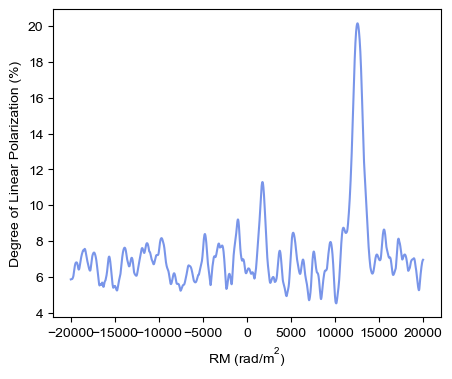

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1562.50it/s]


RM: 12525 +41 -40


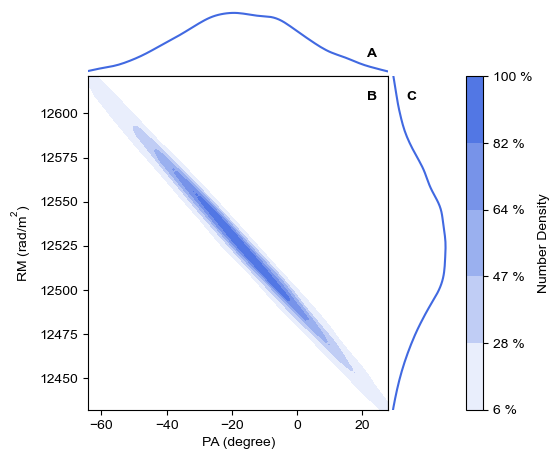

Linear: 19.39_1.07    Circular: -1.06_1.05


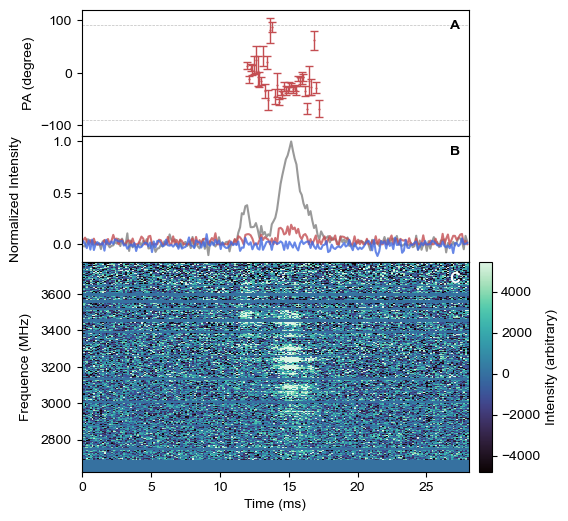

In [4]:
from extract_pulse  import get_pulse
from rm_qu_fitting  import mcmc_fit, plot_mcmc_samp
from rm_synthesis   import synthesis_rm, get_rm, plot_rm_synthesis
from translate_data import translate_file, plot_spec

file_name_list = [i for i in os.listdir('../Data/') if 'csv' not in i]

for i in range(len(file_name_list)):
    file_name                                     = file_name_list[i]
    ##### Extract pulse; 
    I, Q, U, V, freq, tbin                        = translate_file(file_name)
    I, Q, U, _, freq, snr, center_freq            = get_pulse(I, Q, U, V, freq)
    ##### RM synthesis
    rm_list, Linear                               = synthesis_rm(I, Q, U, freq, rm_left=-20000, rm_right=20000)
    RM, RM_error_left, RM_error_right             = get_rm(rm_list, Linear, snr / 2)
    print('RM: {:.0f} +{:.0f} -{:.0f}'.format(RM, RM_error_right, RM_error_left))
    plot_rm_synthesis(rm_list, Linear, save=False)
#    plot_rm_synthesis(rm_list, Linear, save='-{}'.format(file_name))
    rm_max                                        = RM
    
    ##### Squeeze the time dimension and turn the data into one dimension
    Q, U                                          = np.mean(Q, axis=1), np.mean(U, axis=1)
    ##### QU fitting with MCMC, Q and U - 1D numpy array; axis0 is frequency channel
    if file_name == 'uwl_220109_193549_12_669073.calib.pazi.pazi.TSDb4':
        result, RM, RM_error_left, RM_error_right = mcmc_fit(Q, U, freq, rm_left=-20000, rm_right=-10000)
    else:
        result, RM, RM_error_left, RM_error_right = mcmc_fit(Q, U, freq, rm_left=-20000, rm_right=20000)
    print('RM: {:.0f} +{:.0f} -{:.0f}'.format(RM, RM_error_right, RM_error_left))
    plot_mcmc_samp(result, save=False)
#    plot_mcmc_samp(result, save='-{}'.format(file_name))
    
    ##### Plot-Spectrum
    plot_spec(file_name, rm_max, save=False)

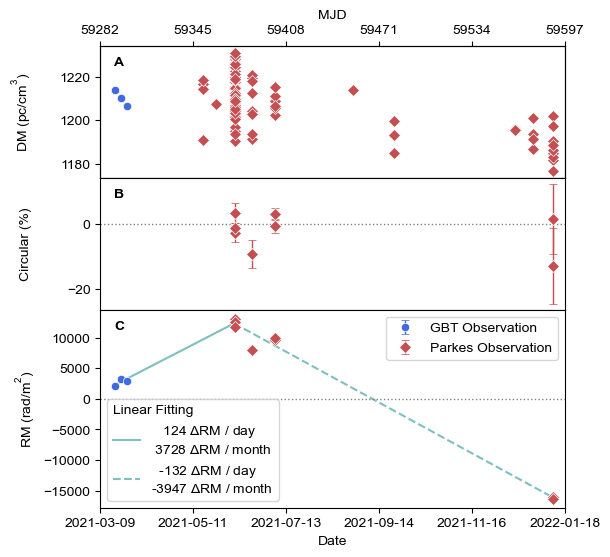

In [9]:
import datetime
from astropy.time import Time

x = [datetime.datetime.strptime('20210319', '%Y%m%d'),
     datetime.datetime.strptime('20210323', '%Y%m%d'),
     datetime.datetime.strptime('20210327', '%Y%m%d'),
     
     datetime.datetime.strptime('20210608', '%Y%m%d'),
     datetime.datetime.strptime('20210608', '%Y%m%d'),
     datetime.datetime.strptime('20210608', '%Y%m%d'),
     
     datetime.datetime.strptime('20210619', '%Y%m%d'),
     datetime.datetime.strptime('20210705', '%Y%m%d'),
     datetime.datetime.strptime('20210705', '%Y%m%d'),
     
     datetime.datetime.strptime('20220109', '%Y%m%d'),
     datetime.datetime.strptime('20220109', '%Y%m%d')
    ]

mjd = np.array(list(Time(x).mjd[:3]) + [
    59373.6091078794, 59373.6109080487, 59373.6517173351, 59384.6323251402,
    59400.4337803355, 59400.4776035281, 59588.8333899777, 59588.9056905966
])

x       = [-2.6, -1.1, 3.5, -9.2, 3.1, -0.5, 1.7, -12.8]
x_error = [3, 1, 3.1, 4.2, 1.8, 2.1, 10.8, 11.7]

y = [
    2168, 3250, 2877,
    12998, 12523, 11743, 8044, 9608, 9908, -16081, -16289
]
y_left_error = [
    49, 71, 159,
    93, 42, 37, 25, 73, 86, 18, 18
]
y_right_error = [
    75, 77, 126,
    74, 40, 34, 19, 91, 96, 18, 17
]

z = [
    1213.8, 1210.1, 1206.7,
    1202.4, 1209.6, 1211.4, 1212.4, 1205.7, 1206.4, 1186.0, 1186.4
]
z_error = [
    0.7, 0.3, 0.2,
    0.2, 0.2, 0.5, 0.2, 0.2, 0.2, 0.2, 0.3
]

pks_data                 = pd.read_csv('../Data/Parkes-DM.csv')
pks_mjd, pks_dm, pks_dme = pks_data.loc[:, ['MJD', 'DM', 'DM_Error']].values.T

def linear(x, a, b):
    return a * x + b

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(7, 1)
plt.subplots_adjust(hspace=0)

parameters = {
    'axes.labelsize':  10,
    'axes.titlesize':  10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
}

plt.rcParams.update(parameters)

ax = plt.subplot(gs[0:2, 0])
plt.errorbar(mjd[:3], z[:3], z_error[:3], fmt='o', color='royalblue', capsize=3, elinewidth=1, mec='white', mew=0.5)
plt.errorbar(pks_mjd, pks_dm, pks_dme, fmt='D', color='r', capsize=3, elinewidth=1, mec='white', mew=0.5)

plt.xticks([])
plt.xlim(np.floor(mjd.min())-10, np.ceil(mjd.max())+8)
plt.ylabel('DM (pc/cm$^3$)', labelpad=18)

ax = ax.twiny()
ax.tick_params(direction = 'out')
ax.set_xticks(np.linspace(0, 1, 6), np.linspace(np.floor(mjd.min())-10, np.ceil(mjd.max())+8, 6).astype(np.int64))
ax.set_xlabel('MJD')

ax = plt.gca()
plt.text(0.03, 0.85, 'A', weight='bold', transform=ax.transAxes)

ax = plt.subplot(gs[2:4, 0])
plt.errorbar(mjd[3:], x, x_error, fmt='D', color='r', capsize=3, elinewidth=1, mec='white', mew=0.5)
plt.hlines(0, np.floor(mjd.min())-10, np.ceil(mjd.max())+8, ls='dotted', lw=1, color='gray')
plt.xlim(np.floor(mjd.min())-10, np.ceil(mjd.max())+8)
plt.ylabel('Circular (%)', labelpad=25)
ax = plt.gca()
plt.text(0.03, 0.85, 'B', weight='bold', transform=ax.transAxes)

ax = plt.subplot(gs[4:, 0])
popt1, pcov1 = curve_fit(linear, mjd[:6], y[:6])
popt2, pcov2 = curve_fit(linear, mjd[3:], y[3:])
turning_point = (popt2[1] - popt1[1]) / (popt1[0] - popt2[0])

a1 = plt.plot(np.linspace(mjd.min(), turning_point, 100), linear(np.linspace(mjd.min(), turning_point, 100), *popt1), 
         color='teal', label='   {:.0f} $\Delta$RM / day\n {:.0f} $\Delta$RM / month'.format(popt1[0], popt1[0]*30),
         alpha=0.5)
a2 = plt.plot(np.linspace(turning_point, mjd.max(), 100), linear(np.linspace(turning_point, mjd.max(), 100), *popt2), 
         color='teal', ls='--', label='  {:.0f} $\Delta$RM / day\n{:.0f} $\Delta$RM / month'.format(popt2[0], popt2[0]*30),
         alpha=0.5)
s1 = plt.errorbar(mjd[:3], y[:3], yerr=[y_left_error[:3], y_right_error[:3]],
             fmt='o', color='royalblue', capsize=3, elinewidth=1, mec='white', mew=0.5, label='GBT Observation')
s2 = plt.errorbar(mjd[3:], y[3:], yerr=[y_left_error[3:], y_right_error[3:]],
             fmt='D', color='r', capsize=3, elinewidth=1, mec='white', mew=0.5, label='Parkes Observation')

plt.hlines(0, np.floor(mjd.min())-10, np.ceil(mjd.max())+8, ls='dotted', lw=1, color='gray')
plt.xticks(np.linspace(np.floor(mjd.min())-10, np.ceil(mjd.max())+8, 6), 
           Time(np.linspace(np.floor(mjd.min())-10, np.ceil(mjd.max())+8, 6), format='mjd').strftime('%Y-%m-%d'), 
           rotation=0)
plt.xlim(np.floor(mjd.min())-10, np.ceil(mjd.max())+8)

legend1 = ax.legend(handles=[s1, s2])
ax.add_artist(legend1)
legend2 = ax.legend(handles=[a1[0], a2[0]], loc='lower left', ncol=1, title='Linear Fitting')
legend2._legend_box.align = 'left'
plt.xlabel('Date')
plt.ylabel('RM (rad/m$^2$)')
ax = plt.gca()
plt.text(0.03, 0.9, 'C', weight='bold', transform=ax.transAxes)

# plt.savefig('../Figure/RM-Time-New.png', format='png', dpi=300, bbox_inches='tight')
plt.show()